# Evaluation Analysis

This notebook summarizes LLM judge evaluation results with improved visuals and consistent styling. I added a shared visual theme and helper functions to keep plots cohesive across sections.

---


In [66]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.column import Column

Project root: /home/dc/Nextcloud/BachelorsThesis/AQuA_Thesis/Code/echr-qa-benchmark


In [67]:
# Visual style settings (centralized)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Use a modern, clean theme and fixed palette for consistency
sns.set_theme(style="whitegrid", palette="muted")

mpl.rcParams.update({
    "figure.dpi": 120,
    "figure.figsize": (10, 4),
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 9,
})

# Shared palette (sliceable by number of metrics)
PALETTE = sns.color_palette("muted", n_colors=6)

# Helper to apply consistent bar styling
def beautify_ax(ax, ylimit=None):
    for p in ax.patches:
        p.set_edgecolor("black")
        p.set_linewidth(0.6)
        p.set_alpha(0.95)
        try:
            p.set_width(0.6)
        except Exception:
            pass
    if ylimit is not None:
        ax.set_ylim(ylimit)
    sns.despine(ax=ax, left=False)
    return ax

print("Visual style configured: PALETTE length=", len(PALETTE))


Visual style configured: PALETTE length= 6


In [ ]:
# All eval files
from pathlib import Path

data_dir = Path('../data')
eval_files = sorted(list(data_dir.glob('eval_*.csv')))

print(f"Found {len(eval_files)} evaluated CSV files with LLM judge scores:")
print("-" * 69)

score_cols = [
    'llm_claim_recall',
    'llm_faithfulness',
    'llm_citation_correctness',
    'llm_citation_semantic_similarity'
]

eval_data = {}
for i, f in enumerate(eval_files, 1):
    file_size = f.stat().st_size / (1024 * 1024)  # Size in MB
    print(f"{i}. {f.name}")
    print(f"   Size: {file_size:.2f} MB")

    try:
        df = pd.read_csv(f)
    except Exception as e:
        print(f"   ERROR reading file: {e}")
        print()
        continue

    key = f.stem.replace('eval_e_', '')
    eval_data[key] = df
    print(f"   Loaded: {len(df)} rows, {df.shape[1]} columns (key='{key}')")

    total_rows = len(df)

    masks = []
    for col in score_cols:
        if col not in df.columns:
            masks.append(pd.Series(False, index=df.index))
            continue

        mask = df[col].notna()
        masks.append(mask)

    if masks:
        all_exist = masks[0]
        for m in masks[1:]:
            all_exist = all_exist & m
        exist_count = int(all_exist.sum())
    else:
        exist_count = 0

    print(f"   LLM scores found in {exist_count}/{total_rows} rows: {'✓' if exist_count == total_rows and total_rows>0 else '✗'}")
    print()

print(f"\nTotal files loaded into eval_data: {len(eval_data)}")

Found 21 evaluated CSV files with LLM judge scores:
---------------------------------------------------------------------
1. eval_e_ron_rag_qwen3_doc_echr_topic_query_echr_retrieve_gptoss_fullnative.csv
   Size: 20.58 MB
   Loaded: 552 rows, 17 columns (key='doc_echr_topic_query_echr_retrieve_gptoss_fullnative')
   LLM scores found in 552/552 rows: ✓

2. eval_e_ron_rag_qwen3_doc_echr_topic_query_echr_retrieve_gptoss_notranslation.csv
   Size: 18.73 MB
   Loaded: 552 rows, 17 columns (key='doc_echr_topic_query_echr_retrieve_gptoss_notranslation')
   LLM scores found in 552/552 rows: ✓

3. eval_e_ron_rag_qwen3_doc_echr_topic_query_echr_retrieve_k2_fullnative.csv
   Size: 20.49 MB
   Loaded: 552 rows, 17 columns (key='doc_echr_topic_query_echr_retrieve_gptoss_fullnative')
   LLM scores found in 552/552 rows: ✓

2. eval_e_ron_rag_qwen3_doc_echr_topic_query_echr_retrieve_gptoss_notranslation.csv
   Size: 18.73 MB
   Loaded: 552 rows, 17 columns (key='doc_echr_topic_query_echr_retrieve_gptos

In [69]:
# metrics columns (exclude categorical 'llm_citation_correctness'; handled separately)
metrics = ['llm_claim_recall', 'llm_faithfulness', 'llm_citation_semantic_similarity']

print('Available keys:' )
for k in sorted(eval_data.keys()):
    print(k)

Available keys:
doc_echr_topic_query_echr_retrieve_gptoss_fullnative
doc_echr_topic_query_echr_retrieve_gptoss_notranslation
doc_echr_topic_query_echr_retrieve_k2_fullnative
doc_echr_topic_query_echr_retrieve_k2_notranslation
doc_echr_topic_query_echr_retrieve_r10528_fullnative
doc_echr_topic_query_echr_retrieve_r10528_notranslation
doc_echr_topic_query_echr_retrieve_ron_gptoss_notranslation
doc_echr_topic_query_echr_retrieve_ron_k2_notranslation
doc_echr_topic_query_echr_retrieve_ron_r10528_notranslation
doc_echr_topic_query_ron_echr_retrieve_ron_gptoss_notranslation
doc_echr_topic_query_ron_echr_retrieve_ron_k2_notranslation
doc_echr_topic_query_ron_echr_retrieve_ron_r10528_notranslation
doc_echr_topic_query_translation_echr_retrieve_gptoss_fulltranslation
doc_echr_topic_query_translation_echr_retrieve_gptoss_halftranslation
doc_echr_topic_query_translation_echr_retrieve_k2_fulltranslation
doc_echr_topic_query_translation_echr_retrieve_k2_halftranslation
doc_echr_topic_query_translat

In [70]:
# Strategy registry: make strategies easy to distinguish and reuse across the notebook
from dataclasses import dataclass
from typing import List, Dict, Optional, Iterable

# Fixed vocab (no genericization; only what we use here)
# Note: we keep canonical vocab WITHOUT the 'doc_' / 'query_' prefixes as requested
DOC_EMBED = [
    'echr_topic',
    'no_instruct',
]

QUERY_EMBED = [
    'echr_retrieve',
    'echr_retrieve_ron',
    'ron_echr_retrieve_ron',
    'translation_echr_retrieve',
    'base',
]

MODELS = ['k2', 'r10528', 'gptoss']

TRANSLATION_STRATEGIES = [
    'notranslation',
    'fullnative',
    'fulltranslation',
    'halftranslation',
]

# The exact, complete list of strategies we support (append here to add new ones)
ALL_STRATEGY_NAMES: List[str] = [
    # doc_echr_topic + query_echr_retrieve (+ model) + translation strategy
    'doc_echr_topic_query_echr_retrieve_gptoss_fullnative',
    'doc_echr_topic_query_echr_retrieve_gptoss_notranslation',
    'doc_echr_topic_query_echr_retrieve_k2_fullnative',
    'doc_echr_topic_query_echr_retrieve_k2_notranslation',
    'doc_echr_topic_query_echr_retrieve_r10528_fullnative',
    'doc_echr_topic_query_echr_retrieve_r10528_notranslation',

    # English instructions revealing Romanian context
    'doc_echr_topic_query_echr_retrieve_ron_gptoss_notranslation',
    'doc_echr_topic_query_echr_retrieve_ron_k2_notranslation',
    'doc_echr_topic_query_echr_retrieve_ron_r10528_notranslation',

    # Romanian instructions
    'doc_echr_topic_query_ron_echr_retrieve_ron_gptoss_notranslation',
    'doc_echr_topic_query_ron_echr_retrieve_ron_k2_notranslation',
    'doc_echr_topic_query_ron_echr_retrieve_ron_r10528_notranslation',

    # Translation pipeline variants
    'doc_echr_topic_query_translation_echr_retrieve_gptoss_fulltranslation',
    'doc_echr_topic_query_translation_echr_retrieve_gptoss_halftranslation',
    'doc_echr_topic_query_translation_echr_retrieve_k2_fulltranslation',
    'doc_echr_topic_query_translation_echr_retrieve_k2_halftranslation',
    'doc_echr_topic_query_translation_echr_retrieve_r10528_fulltranslation',
    'doc_echr_topic_query_translation_echr_retrieve_r10528_halftranslation',

    # Baseline (no instruct, query base)
    'doc_no_instruct_query_base_gptoss_notranslation',
    'doc_no_instruct_query_base_k2_notranslation',
    'doc_no_instruct_query_base_r10528_notranslation',
]

@dataclass(frozen=True)
class Strategy:
    name: str
    doc_embed: str
    query_embed: str
    retrieval_language: str  # 'query_translation_echr_retrieve' vs 'query_echr_retrieve'
    model: str               # 'k2' | 'r10528' | 'gptoss'
    translation_strategy: str  # 'notranslation' | 'fullnative' | 'fulltranslation' | 'halftranslation'
    lang: str = 'ron'
    embedding_model: str = 'qwen3'
    framework: str = 'rag'

    @property
    def key(self) -> str:
        # The key used in eval_data (after filename stem prefix removal)
        return self.name

    def eval_data_key_candidates(self) -> List[str]:
        # Some cells previously referenced keys with an extra 'ron_rag_qwen3_' prefix.
        # We accept both to be resilient without changing other cells.
        return [self.key, f'ron_rag_qwen3_{self.key}']


def _parse_strategy_name(name: str) -> Strategy:
    # Parse via markers 'doc_' and 'query_' (no raises; shapes are known in this project)
    # Expect: 'doc_<doc_part>_query_<query_part>_<model>_<translation>'
    doc_prefix = 'doc_'
    query_marker = '_query_'

    # doc part
    # If structure deviates, fall back to safe defaults without raising
    doc_part = ''
    rest_after_query = ''
    if name.startswith(doc_prefix):
        pos_q = name.find(query_marker, len(doc_prefix))
        if pos_q != -1:
            doc_part = name[len(doc_prefix):pos_q]
            rest_after_query = name[pos_q + len(query_marker):]
        else:
            # No query marker; take everything after 'doc_'
            doc_part = name[len(doc_prefix):]
            rest_after_query = ''
    else:
        # No 'doc_' prefix found
        doc_part = ''
        rest_after_query = ''

    # split the remainder into query, model, translation
    query_part = ''
    model = ''
    trans = ''
    if rest_after_query:
        tokens = rest_after_query.split('_')
        if len(tokens) >= 2:
            model = tokens[-2]
            trans = tokens[-1]
            query_part = '_'.join(tokens[:-2])
        else:
            query_part = rest_after_query

    # retrieval_language: per requirement, bucket into two values
    retrieval_language = (
        'query_translation_echr_retrieve'
        if query_part == 'translation_echr_retrieve' else 'query_echr_retrieve'
    )

    return Strategy(
        name=name,
        doc_embed=doc_part or '',
        query_embed=query_part or '',
        retrieval_language=retrieval_language,
        model=model or '',
        translation_strategy=trans or '',
    )

# Build registry
STRATEGIES: List[Strategy] = [_parse_strategy_name(n) for n in ALL_STRATEGY_NAMES]
BY_NAME: Dict[str, Strategy] = {s.name: s for s in STRATEGIES}
BY_MODEL: Dict[str, List[Strategy]] = {m: [s for s in STRATEGIES if s.model == m] for m in MODELS}


def list_strategies(*, as_dataframe: bool = True):
    rows = [
        {
            'name': s.name,
            'doc_embed': s.doc_embed,
            'query_embed': s.query_embed,
            'retrieval_language': s.retrieval_language,
            'model': s.model,
            'translation_strategy': s.translation_strategy,
            'lang': s.lang,
            'embedding_model': s.embedding_model,
            'framework': s.framework,
        }
        for s in STRATEGIES
    ]
    if as_dataframe:
        return pd.DataFrame(rows)
    return rows


def select_strategies(
    *,
    doc_embed: Optional[str] = None,
    query_embed: Optional[str] = None,
    retrieval_language: Optional[str] = None,
    model: Optional[str] = None,
    translation_strategy: Optional[str] = None,
) -> List[Strategy]:
    def _ok(val: str, want: Optional[str]) -> bool:
        return want is None or val == want

    out: List[Strategy] = []
    for s in STRATEGIES:
        if not _ok(s.doc_embed, doc_embed):
            continue
        if not _ok(s.query_embed, query_embed):
            continue
        if not _ok(s.retrieval_language, retrieval_language):
            continue
        if not _ok(s.model, model):
            continue
        if not _ok(s.translation_strategy, translation_strategy):
            continue
        out.append(s)
    return out


def get_eval_df(strategy_or_name: str | Strategy) -> Optional[pd.DataFrame]:
    s = BY_NAME[strategy_or_name] if isinstance(strategy_or_name, str) else strategy_or_name
    for cand in s.eval_data_key_candidates():
        if 'eval_data' in globals() and cand in eval_data:
            return eval_data[cand]
    return None


def strategies_to_df(strategies: Iterable[Strategy]) -> pd.DataFrame:
    return pd.DataFrame([
        {
            'name': s.name,
            'doc_embed': s.doc_embed,
            'query_embed': s.query_embed,
            'retrieval_language': s.retrieval_language,
            'model': s.model,
            'translation_strategy': s.translation_strategy,
            'lang': s.lang,
            'embedding_model': s.embedding_model,
            'framework': s.framework,
        }
        for s in strategies
    ])


In [77]:
# Comparison 1: Model Performance (R1_0528 vs GPT-OSS-120B vs K2)
print("## Comparison 1: Model Performance")
print("-" * 69)
print("\nComparing best performer setups across different models:")

model_order = [
    ("r10528", "R1_0528"),
    ("gptoss", "GPT-OSS-120B"),
    ("k2", "K2"),
]

results = []
for model_key, model_name in model_order:
    strategies = select_strategies(
        doc_embed="echr_topic",
        query_embed="echr_retrieve",
        translation_strategy="notranslation",
        model=model_key,
    )
    if not strategies:
        print(f"Warning: No strategy found for model={model_key}")
        continue

    s = strategies[0]
    df = get_eval_df(s)
    if df is None:
        print(f"Warning: No eval DataFrame found for strategy '{s.name}'")
        continue

    row = {"Model": model_name}
    for metric in metrics:
        if metric in df.columns:
            valid_mask = df[metric].notna() & ~df[metric].isin([-1, -2])
            valid_scores = df.loc[valid_mask, metric]
            if len(valid_scores) == 0:
                row[metric] = "N/A"
            else:
                mean_val = valid_scores.mean()
                std_val = valid_scores.std()
                row[metric] = f"{mean_val:.3f} ± {std_val:.3f}"
        else:
            row[metric] = "N/A"
    results.append(row)

if results:
    comparison_1_df = pd.DataFrame(results)
    print("\n### Mean ± Std for each metric:")
    print(comparison_1_df.to_string(index=False))
else:
    print("No data found for comparison 1")
print("\n")

## Comparison 1: Model Performance
---------------------------------------------------------------------

Comparing best performer setups across different models:

### Mean ± Std for each metric:
       Model llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
     R1_0528    3.111 ± 1.444    3.714 ± 1.441                    3.557 ± 1.049
GPT-OSS-120B    3.366 ± 1.401    2.712 ± 1.339                    3.627 ± 0.995
          K2    3.105 ± 1.346    3.418 ± 1.457                    3.546 ± 1.013




## Bar plots by strategy family (mean scores per metric)


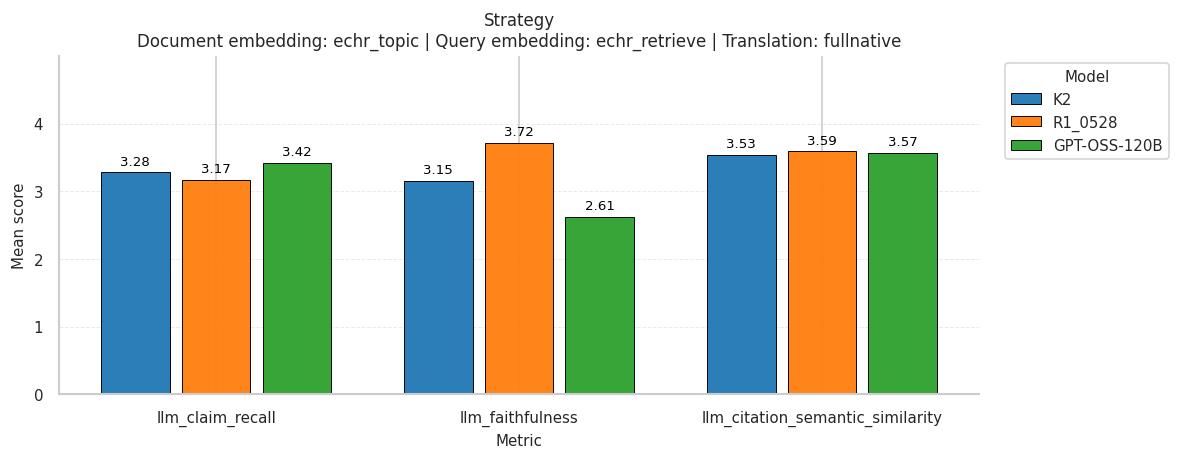

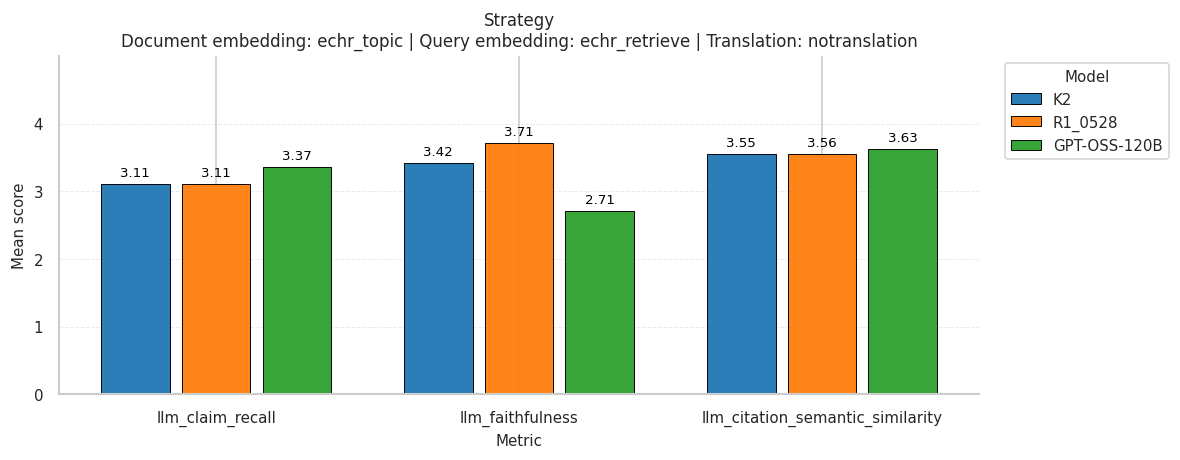

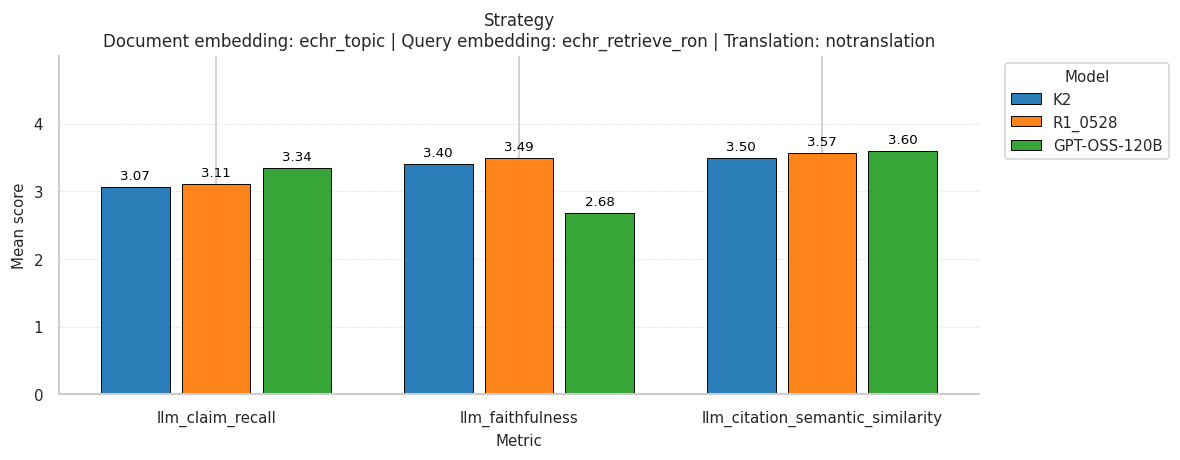

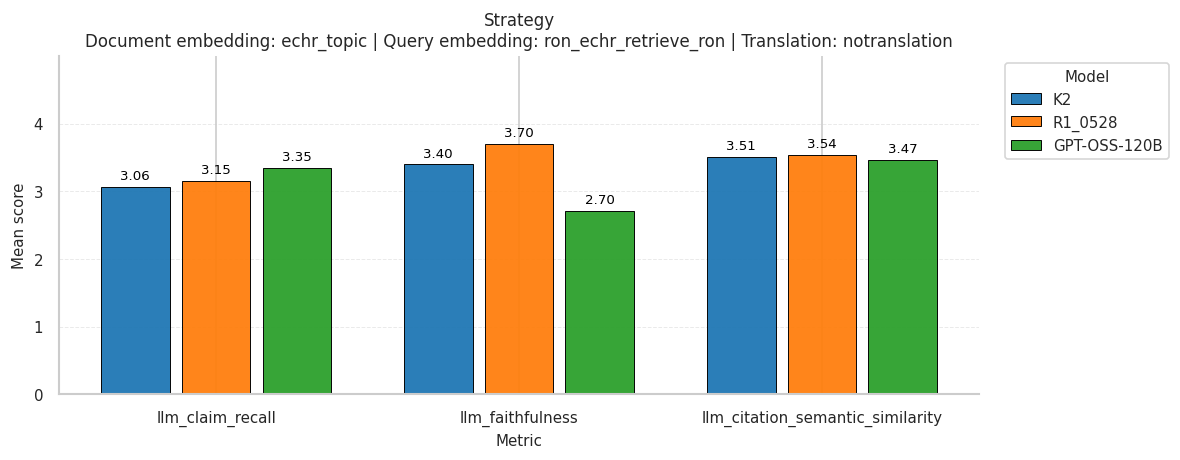

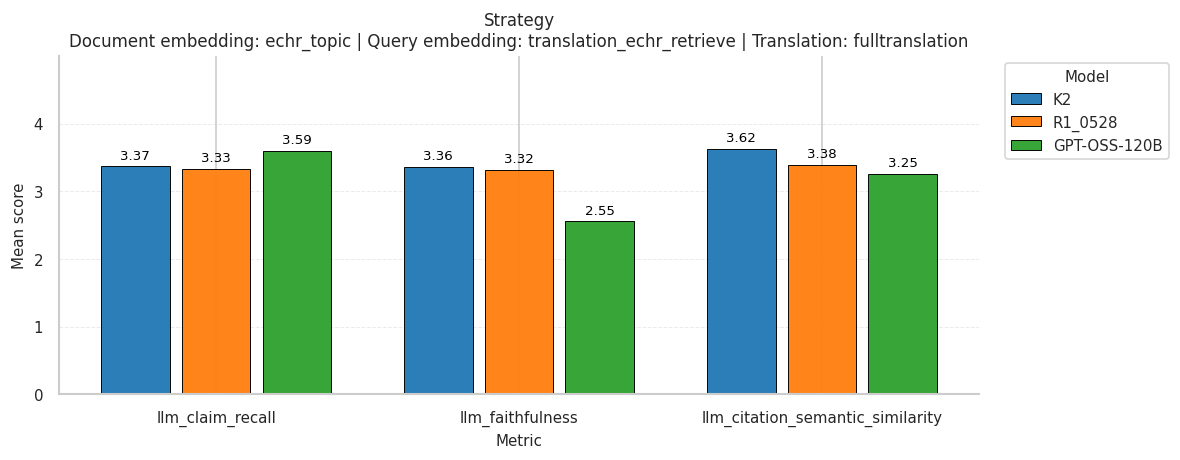

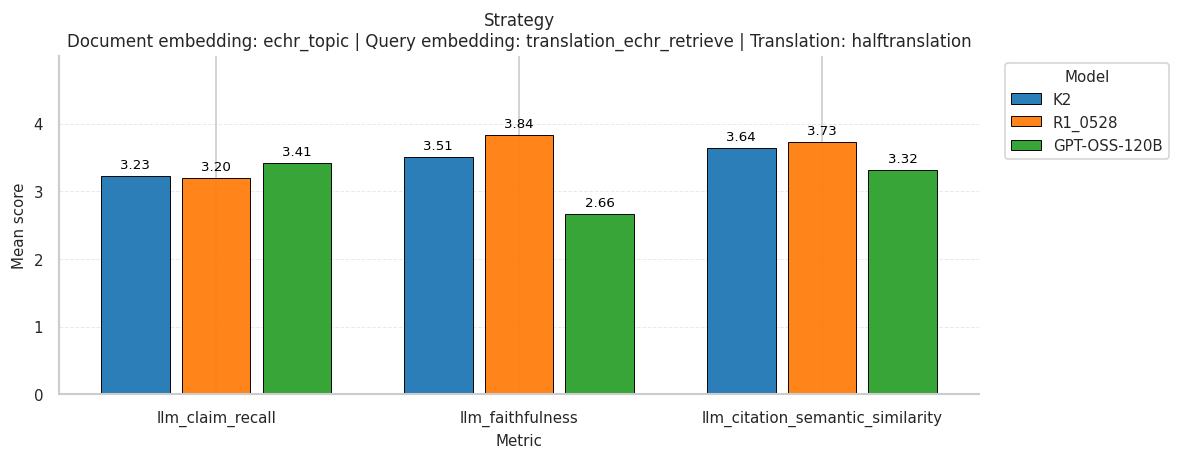

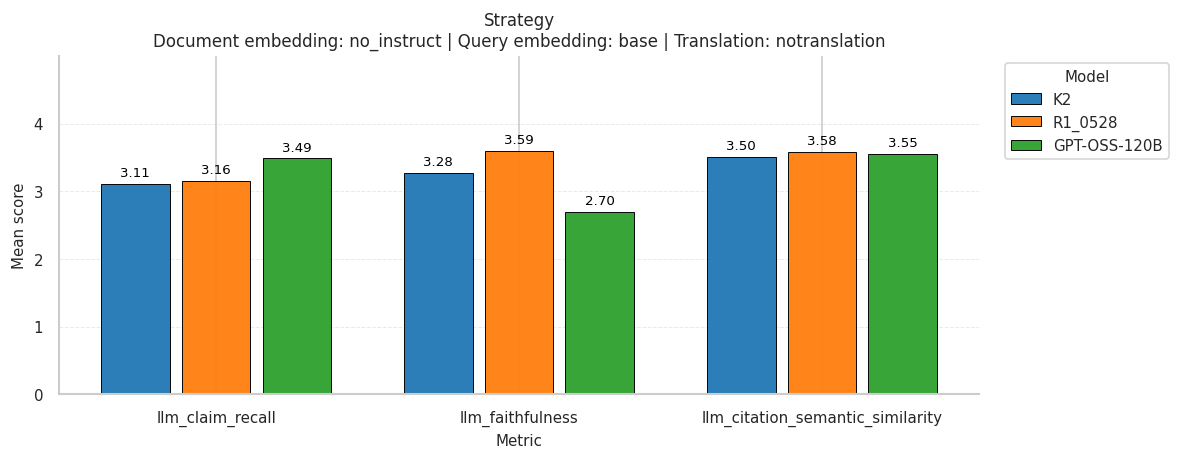

Plotted 7 strategy family figures.


In [72]:
# Grouped bar plots per strategy family: metrics on X, models as hues (Matplotlib only)
print("## Bar plots by strategy family (mean scores per metric)")
print("=" * 80)

from collections import defaultdict

# Define how we group strategies into a "family" (same doc/query/translation, varying model)
def _family_key(s: Strategy):
    return (s.doc_embed, s.query_embed, s.translation_strategy)

# Human-readable model names
model_display = {
    "r10528": "R1_0528",
    "gptoss": "GPT-OSS-120B",
    "k2": "K2",
}

# Build families
families = defaultdict(list)
for s in STRATEGIES:
    families[_family_key(s)].append(s)

# Helper: compute mean per metric for a given strategy, with sentinel filtering
def _metric_means(s: Strategy):
    df = get_eval_df(s)
    if df is None:
        return None
    out = {}
    for metric in metrics:
        if metric in df.columns:
            series = df[metric]
            valid_mask = series.notna() & ~series.isin([-1, -2])
            vals = series[valid_mask]
            if len(vals) > 0:
                out[metric] = float(vals.mean())
    return out if out else None

# Plot one figure per family
plotted = 0

for (doc_embed, query_embed, translation_strategy), strategies in sorted(families.items()):
    # Choose at most one strategy per model within this family
    best_by_model = {}
    for s in strategies:
        if s.model in MODELS:
            # Keep the first seen (all names are unique per model in this project)
            if s.model not in best_by_model:
                best_by_model[s.model] = s

    available_models = [m for m in MODELS if m in best_by_model]
    if len(available_models) < 2:
        # Need at least 2 models to make a meaningful comparison
        continue

    # Build plotting dataframe
    rows = []
    for mkey in available_models:
        s = best_by_model[mkey]
        means = _metric_means(s)
        if not means:
            continue
        for metric_name in metrics:
            if metric_name in means:
                rows.append({
                    "Metric": metric_name,
                    "Model": model_display.get(mkey, mkey),
                    "Mean": means[metric_name],
                })

    if not rows:
        continue

    plot_df = pd.DataFrame(rows)
    order_metrics = metrics
    order_models = [model_display.get(m, m) for m in available_models]

    # Two-line title: top 'Strategy', bottom with choices using ':'
    title_top = "Strategy"
    title_bottom = f"Document embedding: {doc_embed} | Query embedding: {query_embed} | Translation: {translation_strategy}"
    full_title = title_top + '\n' + title_bottom

    # Prepare grouped bars with Matplotlib
    fig, ax = plt.subplots(figsize=(10, 4))
    # Use a predefined Matplotlib palette
    tab10 = plt.get_cmap('tab10').colors
    model_colors = {model: tab10[i % len(tab10)] for i, model in enumerate(order_models)}

    # Pivot to wide for easy grouping
    wide = plot_df.pivot(index='Metric', columns='Model', values='Mean').reindex(order_metrics)

    x = np.arange(len(order_metrics))
    n_hues = len(order_models)
    total_width = 0.8
    # Make individual bars thinner (keep group width the same)
    bar_w = total_width / max(n_hues, 1) * 0.85
    offsets = [(i - (n_hues - 1) / 2) * (total_width / n_hues) for i in range(n_hues)]

    for i, model_name in enumerate(order_models):
        vals = wide[model_name] if model_name in wide.columns else pd.Series([np.nan] * len(order_metrics), index=order_metrics)
        bars = ax.bar(
            x + offsets[i],
            vals.values,
            width=bar_w,
            label=model_name,
            color=model_colors[model_name],
            edgecolor='black',
            linewidth=0.6,
            alpha=0.95,
        )
        # Annotate each bar with its score above the bar
        for bar, val in zip(bars, vals.values):
            if not np.isnan(val):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.07,
                    f"{val:.2f}",
                    ha='center', va='bottom', fontsize=8, color='black',
                )

    # Aesthetics without seaborn
    ax.set_title(full_title, fontsize=10)
    ax.set_ylabel("Mean score", fontsize=9)
    ax.set_xlabel("Metric", fontsize=9)
    ax.set_xticks(x)
    ax.set_xticklabels(order_metrics, fontsize=9)
    ax.set_ylim(0, 5)
    ax.set_yticks(np.arange(0, 5, 1))
    ax.tick_params(axis="y", labelsize=9)
    # Light grid and despine
    ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9, title_fontsize=9)
    fig.tight_layout()
    plt.show()
    plotted += 1

print(f"Plotted {plotted} strategy family figures.")


In [81]:
# Comparison 2: Translation Strategies Impact
print("## Comparison 2: Translation Strategies Impact")
print("=" * 80)

# K2 Model
print("\n### K2 Model - Translation Strategies:")
translation_comparison_k2 = {
    'No Translation': 'doc_echr_topic_query_echr_retrieve_k2_notranslation',
    'Half Translation': 'doc_echr_topic_query_translation_echr_retrieve_k2_halftranslation',
    'Full Translation': 'doc_echr_topic_query_translation_echr_retrieve_k2_fulltranslation',
    'Full Native': 'doc_echr_topic_query_echr_retrieve_k2_fullnative'
}

results = []
for strategy_name, file_key in translation_comparison_k2.items():
    if file_key in eval_data:
        df = eval_data[file_key]
        row = {'Translation Strategy': strategy_name}
        for metric in metrics:
            if metric in df.columns:
                valid_scores = df[df[metric] != -1][metric]
                mean_val = valid_scores.mean()
                std_val = valid_scores.std()
                row[metric] = f"{mean_val:.3f} ± {std_val:.3f}"
            else:
                row[metric] = "N/A"
        results.append(row)

if results:
    comparison_2_df = pd.DataFrame(results)
    print(comparison_2_df.to_string(index=False))

# R1_0528 Model
print("\n### R1_0528 Model - Translation Strategies:")
translation_comparison_r1 = {
    'No Translation': 'doc_echr_topic_query_echr_retrieve_r10528_notranslation',
    'Half Translation': 'doc_echr_topic_query_translation_echr_retrieve_r10528_halftranslation',
    'Full Translation': 'doc_echr_topic_query_translation_echr_retrieve_r10528_fulltranslation',
    'Full Native': 'doc_echr_topic_query_echr_retrieve_r10528_fullnative'
}

results = []
for strategy_name, file_key in translation_comparison_r1.items():
    if file_key in eval_data:
        df = eval_data[file_key]
        row = {'Translation Strategy': strategy_name}
        for metric in metrics:
            if metric in df.columns:
                valid_scores = df[df[metric] != -1][metric]
                mean_val = valid_scores.mean()
                std_val = valid_scores.std()
                row[metric] = f"{mean_val:.3f} ± {std_val:.3f}"
            else:
                row[metric] = "N/A"
        results.append(row)

if results:
    comparison_2b_df = pd.DataFrame(results)
    print(comparison_2b_df.to_string(index=False))

# GPT-OSS Model
print("\n### GPT-OSS-120B Model - Translation Strategies:")
translation_comparison_gpt = {
    'No Translation': 'doc_echr_topic_query_echr_retrieve_gptoss_notranslation',
    'Half Translation': 'doc_echr_topic_query_translation_echr_retrieve_gptoss_halftranslation',
    'Full Translation': 'doc_echr_topic_query_translation_echr_retrieve_gptoss_fulltranslation',
    'Full Native': 'doc_echr_topic_query_echr_retrieve_gptoss_fullnative'
}

results = []
for strategy_name, file_key in translation_comparison_gpt.items():
    if file_key in eval_data:
        df = eval_data[file_key]
        row = {'Translation Strategy': strategy_name}
        for metric in metrics:
            if metric in df.columns:
                valid_scores = df[df[metric] != -1][metric]
                mean_val = valid_scores.mean()
                std_val = valid_scores.std()
                row[metric] = f"{mean_val:.3f} ± {std_val:.3f}"
            else:
                row[metric] = "N/A"
        results.append(row)

if results:
    comparison_2c_df = pd.DataFrame(results)
    print(comparison_2c_df.to_string(index=False))

print("\n")

## Comparison 2: Translation Strategies Impact

### K2 Model - Translation Strategies:
Translation Strategy llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
      No Translation    3.105 ± 1.346    3.418 ± 1.457                    2.752 ± 2.158
    Half Translation    3.226 ± 1.399    3.513 ± 1.455                    2.826 ± 2.180
    Full Translation    3.368 ± 1.403    3.361 ± 1.472                    2.817 ± 2.202
         Full Native    3.279 ± 1.431    3.152 ± 1.478                    2.745 ± 2.165

### R1_0528 Model - Translation Strategies:
Translation Strategy llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
      No Translation    3.111 ± 1.444    3.714 ± 1.441                    2.766 ± 2.173
    Half Translation    3.203 ± 1.373    3.839 ± 1.436                    2.898 ± 2.200
    Full Translation    3.328 ± 1.524    3.317 ± 1.748                    2.616 ± 2.288
         Full Native    3.174 ± 1.462    3.717 ± 1.456                    2.

In [82]:
# Comparison 3a: Instruction Strategies (Baseline vs ECHR)
print("## Comparison 3a: Instruction Strategies - Baseline vs ECHR")
print("=" * 80)
print("\nComparing NO_INSTRUCT/QUERY_BASE vs ECHR_TOPIC_QUERY/ECHR_RETRIEVE:")

# For each model
for model_suffix, model_name in [('r10528', 'R1_0528'), ('gptoss', 'GPT-OSS-120B'), ('k2', 'K2')]:
    print(f"\n### {model_name} Model:")
    
    instruction_comparison = {
        'Baseline (No Instruct)': f'doc_no_instruct_query_base_{model_suffix}_notranslation',
        'ECHR Instruct': f'doc_echr_topic_query_echr_retrieve_{model_suffix}_notranslation'
    }
    
    results = []
    for strategy_name, file_key in instruction_comparison.items():
        if file_key in eval_data:
            df = eval_data[file_key]
            row = {'Instruction Strategy': strategy_name}
            for metric in metrics:
                if metric in df.columns:
                    valid_scores = df[df[metric] != -1][metric]
                    mean_val = valid_scores.mean()
                    std_val = valid_scores.std()
                    row[metric] = f"{mean_val:.3f} ± {std_val:.3f}"
                else:
                    row[metric] = "N/A"
            results.append(row)
    
    if results:
        comparison_3a_df = pd.DataFrame(results)
        print(comparison_3a_df.to_string(index=False))

print("\n")

## Comparison 3a: Instruction Strategies - Baseline vs ECHR

Comparing NO_INSTRUCT/QUERY_BASE vs ECHR_TOPIC_QUERY/ECHR_RETRIEVE:

### R1_0528 Model:
  Instruction Strategy llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
Baseline (No Instruct)    3.159 ± 1.394    3.591 ± 1.453                    2.788 ± 2.162
         ECHR Instruct    3.111 ± 1.444    3.714 ± 1.441                    2.766 ± 2.173

### GPT-OSS-120B Model:
  Instruction Strategy llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
Baseline (No Instruct)    3.486 ± 1.403    2.701 ± 1.368                    2.762 ± 2.151
         ECHR Instruct    3.366 ± 1.401    2.712 ± 1.339                    2.824 ± 2.174

### K2 Model:
  Instruction Strategy llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
Baseline (No Instruct)    3.114 ± 1.358    3.277 ± 1.513                    2.718 ± 2.149
         ECHR Instruct    3.105 ± 1.346    3.418 ± 1.457                    2.752 ± 2.158



In [83]:
# Comparison 3b: Language Instruction Variants
print("## Comparison 3b: Language Instruction Variants")
print("=" * 80)
print("\nComparing different language instruction approaches:")
print("- ECHR_RETRIEVE: English instructions")
print("- ECHR_RETRIEVE_RON: English instructions revealing Romanian context")
print("- RON_ECHR_RETRIEVE_RON: Romanian instructions")

# For each model
for model_suffix, model_name in [('r10528', 'R1_0528'), ('gptoss', 'GPT-OSS-120B'), ('k2', 'K2')]:
    print(f"\n### {model_name} Model:")
    
    language_comparison = {
        'English Instructions': f'doc_echr_topic_query_echr_retrieve_{model_suffix}_notranslation',
        'English Revealing Romanian': f'doc_echr_topic_query_echr_retrieve_ron_{model_suffix}_notranslation',
        'Romanian Instructions': f'doc_echr_topic_query_ron_echr_retrieve_ron_{model_suffix}_notranslation'
    }
    
    results = []
    for strategy_name, file_key in language_comparison.items():
        if file_key in eval_data:
            df = eval_data[file_key]
            row = {'Language Variant': strategy_name}
            for metric in metrics:
                if metric in df.columns:
                    valid_scores = df[df[metric] != -1][metric]
                    mean_val = valid_scores.mean()
                    std_val = valid_scores.std()
                    row[metric] = f"{mean_val:.3f} ± {std_val:.3f}"
                else:
                    row[metric] = "N/A"
            results.append(row)
    
    if results:
        comparison_3b_df = pd.DataFrame(results)
        print(comparison_3b_df.to_string(index=False))

print("\n")

## Comparison 3b: Language Instruction Variants

Comparing different language instruction approaches:
- ECHR_RETRIEVE: English instructions
- ECHR_RETRIEVE_RON: English instructions revealing Romanian context
- RON_ECHR_RETRIEVE_RON: Romanian instructions

### R1_0528 Model:
          Language Variant llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
      English Instructions    3.111 ± 1.444    3.714 ± 1.441                    2.766 ± 2.173
English Revealing Romanian    3.105 ± 1.362    3.494 ± 1.457                    2.771 ± 2.179
     Romanian Instructions    3.154 ± 1.435    3.701 ± 1.415                    2.746 ± 2.171

### GPT-OSS-120B Model:
          Language Variant llm_claim_recall llm_faithfulness llm_citation_semantic_similarity
      English Instructions    3.366 ± 1.401    2.712 ± 1.339                    2.824 ± 2.174
English Revealing Romanian    3.344 ± 1.408    2.683 ± 1.389                    2.803 ± 2.170
     Romanian Instructions    3.351 ± 1.3

## Comparison 4: Citation Correctness (categorical)

We excluded `llm_citation_correctness` from the numeric summaries because it is a categorical metric (0–3). Below we compare the distribution of categories across the three models (`R1_0528`, `GPT-OSS-120B`, `K2`) using the same "no translation" setups as in earlier comparisons.

Categories:
- 0: Correctness doesn't apply due to missing citations or major hallucinations.
- 1: Any aspects were not backed at all by its own citations, but supported by other sentences' citations.
- 2: All aspects are backed by its own citations, but other sentences' citations would have been way better to prove the claim.
- 3: All aspects that are backed by citations are backed by its own citations and these are the most suitable citations for the claim.

Note: Values `-1` and `-2` are treated as a single `N/A` category in the plots and tables below.

## Comparison 4: Citation Correctness Distribution

Counts per category:
Category      0: N/A or hallucinations  1: Not backed by own citations  2: Backed, better citations exist  3: Correct and most suitable
Model                                                                                                                                  
GPT-OSS-120B                        37                             237                                 97                           181
K2                                  36                             138                                 44                           334
R1_0528                             37                              94                                 41                           380

Percentages per category:
Category      0: N/A or hallucinations  1: Not backed by own citations  2: Backed, better citations exist  3: Correct and most suitable
Model                                                                               

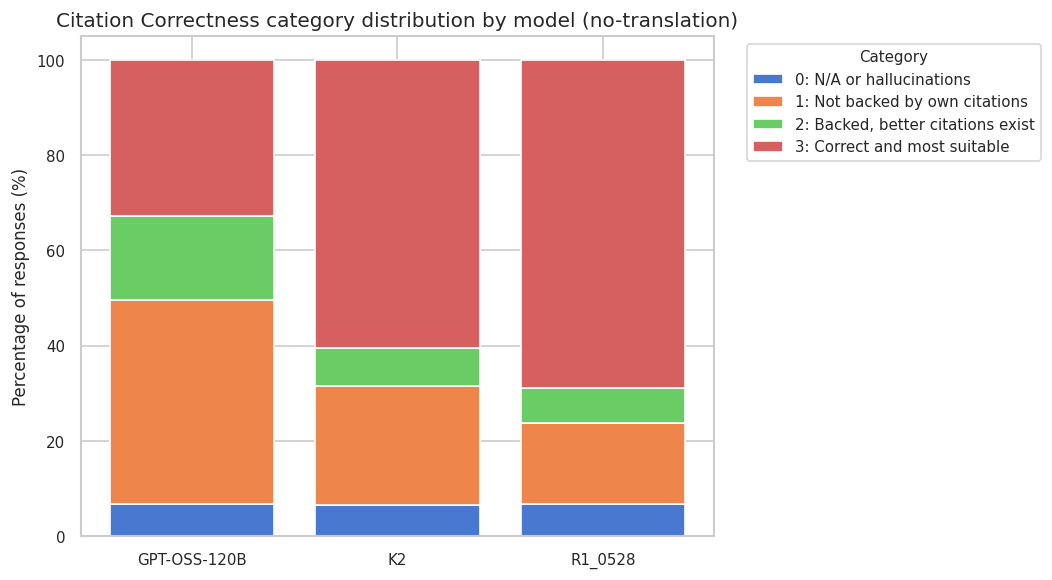

In [84]:
# Build and visualize categorical distributions for citation correctness across models
print("## Comparison 4: Citation Correctness Distribution")
print("=" * 80)

# Keys used earlier for no-translation best-performer setups
model_keys = {
    'R1_0528': 'doc_echr_topic_query_echr_retrieve_r10528_notranslation',
    'GPT-OSS-120B': 'doc_echr_topic_query_echr_retrieve_gptoss_notranslation',
    'K2': 'doc_echr_topic_query_echr_retrieve_k2_notranslation'
}

# Category labels (for nicer display)
cat_labels = {
    0: "0: N/A or hallucinations",
    1: "1: Not backed by own citations",
    2: "2: Backed, better citations exist",
    3: "3: Correct and most suitable"
}

# Aggregate counts per category
count_frames = []
for model_name, key in model_keys.items():
    if key not in eval_data:
        print(f"Warning: {key} not found; skipping {model_name}")
        continue
    df = eval_data[key]
    if 'llm_citation_correctness' not in df.columns:
        print(f"Warning: 'llm_citation_correctness' missing in {key}; skipping {model_name}")
        continue
    # Drop NaNs and ensure integers where possible
    series = df['llm_citation_correctness'].dropna()
    # Only keep values 0..3
    series = series[series.isin([0, 1, 2, 3])].astype(int)
    counts = series.value_counts().reindex([0, 1, 2, 3], fill_value=0)
    tmp = counts.rename(index=cat_labels).rename_axis('Category').reset_index(name='Count')
    tmp['Model'] = model_name
    tmp['Total'] = tmp['Count'].sum()
    tmp['Percent'] = (tmp['Count'] / tmp['Total'].where(tmp['Total'] != 0, np.nan)) * 100
    count_frames.append(tmp)

if count_frames:
    cat_df = pd.concat(count_frames, ignore_index=True)
    # Pivot for a clean table (counts)
    table_counts = cat_df.pivot(index='Model', columns='Category', values='Count').fillna(0).astype(int)
    table_perc = cat_df.pivot(index='Model', columns='Category', values='Percent').fillna(0).round(1)

    print("\nCounts per category:")
    print(table_counts.to_string())

    print("\nPercentages per category:")
    print(table_perc.to_string())

    # Stacked bar chart on percentages
    plt.figure(figsize=(9, 5))
    order = [cat_labels[i] for i in [0, 1, 2, 3]]
    bottom = np.zeros(len(table_perc))
    x = np.arange(len(table_perc.index))
    for cat in order:
        vals = table_perc[cat].values if cat in table_perc.columns else np.zeros(len(table_perc))
        plt.bar(x, vals, bottom=bottom, label=cat)
        bottom += vals
    plt.xticks(x, table_perc.index)
    plt.ylabel('Percentage of responses (%)')
    plt.title('Citation Correctness category distribution by model (no-translation)')
    plt.legend(title='Category', bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No data available to compute citation correctness distribution.")